In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

import math

import time

import dataloader
import models
import training_fun

import optuna

import joblib

import pygad

import HydroErr

c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 3

N_CATCHMENTS = 157

# training hyperparameters

use_amp = True
compile_model = False

if compile_model:
    torch.set_float32_matmul_precision("high")

memory_saving = False
if memory_saving:
    storge_device = "cpu"
    computing_device = DEVICE
    VAL_STEPS = 500
else:
    storge_device = DEVICE
    computing_device = DEVICE

In [3]:
embedding = torch.load("data/final_lstm_embedding2.pt", map_location=torch.device('cpu')).to(computing_device)
decoder = torch.load("data/final_lstm_decoder2.pt", map_location=torch.device('cpu')).to(computing_device)

embedding.eval()
decoder.eval()

# dimension of embedding
catchment_embeddings=[x.data for x in embedding.parameters()][0]
LATENT_dim = catchment_embeddings.shape[1]

In [4]:
dtrain_val = dataloader.Forcing_Data(
    "data/data_train_val_CARAVAN_CH.csv",
    record_length=10957,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

# dtrain = dataloader.Forcing_Data(
#     "camels_train.csv",
#     record_length=2922,
#     storge_device=storge_device,
#     seq_length=SEQ_LENGTH,
#     target_seq_length=TARGET_SEQ_LENGTH,
#     base_length=BASE_LENGTH,
# )

# dval = dataloader.Forcing_Data(
#     "camels_val.csv",
#     record_length=1095,
#     storge_device=storge_device,
#     seq_length=SEQ_LENGTH,
#     target_seq_length=TARGET_SEQ_LENGTH,
#     base_length=BASE_LENGTH,
# )

dtest = dataloader.Forcing_Data(
    "data/data_test_CARAVAN_CH.csv",
    record_length=4018,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

In [5]:
class Objective_builder:
    def __init__(self, x, y, eval_fun):
        self.eval_fun = eval_fun
        self.x = x.contiguous()
        self.y = y.contiguous()
    
    def eval(self, ga_instance, solution, solution_idx):
        
        # numpy to torch tensor
        solution = torch.from_numpy(solution).unsqueeze(0).to(dtype=torch.float32).to(computing_device)
        solution = solution.expand(self.x.shape[0], -1)
        
        # BASE_LENGTH is from global
        pred = decoder.decode(solution, self.x).view(-1).detach().cpu().numpy()

        ob = self.y.view(-1).detach().cpu().numpy()
        
        gof = self.eval_fun(simulated_array=pred, observed_array=ob)
        
        return gof

In [6]:
x_batch_train_val, y_batch_train_val = dtrain_val.get_val_batch()
x_batch_test, y_batch_test = dtest.get_val_batch()

In [7]:
# Hyperparameters of GA
num_generations = 500
num_parents_mating = 10

sol_per_pop = 100
num_genes = LATENT_dim

init_range_low = catchment_embeddings.detach().cpu().min().numpy().tolist()
init_range_high = catchment_embeddings.detach().cpu().max().numpy().tolist()

parent_selection_type = "sss"

crossover_type = "single_point"

mutation_type = "random"
mutation_probability = 0.25

In [8]:
def fitting_wrapper(selected_catchment):

    # Subsetting training, validation, and test data of selected catchments
    x_train_val = x_batch_train_val[:,selected_catchment,:,:].to(computing_device)
    y_train_val = y_batch_train_val[:,selected_catchment,:].to(computing_device)

    x_test = x_batch_test[:,selected_catchment,:,:].to(computing_device)
    y_test = y_batch_test[:,selected_catchment,:].to(computing_device)

    # Creating evaluation functions
    fn_train_val = Objective_builder(x_train_val,y_train_val,HydroErr.kge_2009)
    fn_test = Objective_builder(x_test,y_test,HydroErr.kge_2009)

    # Identifying optimal number of generations
    ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fn_train_val.eval,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        init_range_low=init_range_low,
                        init_range_high=init_range_high,
                        parent_selection_type=parent_selection_type,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_probability = mutation_probability,
                        stop_criteria="saturate_5")

    ga_instance.run()

    # Evaluating best solution
    #solution = ga_instance.best_solutions[np.argmax(val_losses),:]
    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    return fn_test.eval(ga_instance, solution, 1), solution

In [9]:
calibrated_KGES = np.ones(N_CATCHMENTS)
camels_embeddings = np.ones([N_CATCHMENTS, LATENT_dim])

for i in range(N_CATCHMENTS):
    print(f'i={i} starts')
    calibrated_KGES[i], camels_embeddings[i,:]  = fitting_wrapper(i)
    print(f'fit={calibrated_KGES[i]}')

i=0 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [10592 10593 10594 10595 10596 10597 10598 10599 10600 10601 10602 10603
 10604 10605 10606 10607 10608 10609 10610 10611 10612 10613 10614 10615
 10616 10617 10618 10619 10620 10621 10622 10623 10624 10625 10626 10627
 10628 10629 10630 10631 10632 10633 10634 10635 10636 10637 10638 10639
 10640 10641 10642 10643 10644 10645 10646 10647 10648 10649 10650 10651
 10652 10653 10654 10655 10656 10657 10658 10659 10660 10661 10662 10663
 10664 10665 10666 10667 10668 10669 10670 10671 10672 10673 10674 10675
 10676 10677 10678 10679 10680 10681 10682 10683 10684 10685 10686 10687
 10688 10689 10690 10691 10692 10693 10694 10695 10696 10697 10698 10699
 10700 10701 10702 10703 10704 10705 10706 10707 10708 10709 10710 10711
 10712 10713 10714 10715 10716 10717 10718 10719 10720 10721 10722 10723
 10724 10725 10726 10727 10728 10729 10730 10731 10732 10733 10734 10735
 10736 10737 10738 10

fit=0.8848610546852012
i=1 starts
fit=0.921631909242695
i=2 starts
fit=0.8754698091294393
i=3 starts
fit=0.8400113803361645
i=4 starts
fit=0.8677461734017811
i=5 starts
fit=0.8065734822802173
i=6 starts
fit=0.8599543085559296
i=7 starts
fit=0.7637537179322444
i=8 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [    0     1     2 ... 10947 10948 10949] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.8744046499785672
i=9 starts
fit=0.8753676715553266
i=10 starts
fit=0.799921480079513
i=11 starts
fit=-0.9891125560792677
i=12 starts
fit=0.7870486170260673
i=13 starts
fit=0.8748248918172722
i=14 starts
fit=0.7104500881461985
i=15 starts
fit=0.8388391110291846
i=16 starts
fit=0.9089558522611747
i=17 starts
fit=0.7606909901662474
i=18 starts
fit=0.616919500538107
i=19 starts
fit=0.8493957810169854
i=20 starts
fit=0.7576479855972598
i=21 starts
fit=0.762837877057325
i=22 starts
fit=0.8358068490934414
i=23 starts
fit=0.9043562910756506
i=24 starts
fit=0.8833610613964843
i=25 starts
fit=0.8376050010911271
i=26 starts
fit=0.3140557747630466
i=27 starts
fit=0.7288532548399923
i=28 starts
fit=0.8661782024507902
i=29 starts
fit=0.9537008496220017
i=30 starts
fit=0.7358043069807119
i=31 starts
fit=0.8709204407226071
i=32 starts
fit=0.7167403992636656
i=33 starts
fit=0.7827883806115743
i=34 starts
fit=0.7913415341714148
i=35 starts
fit=0.8421195968279049
i=36 starts
fit=0.848519720176883
i

c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [  250   251   252 ... 10947 10948 10949] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.5028994376999573
i=40 starts
fit=0.913302153011801
i=41 starts
fit=0.655087968266695
i=42 starts
fit=0.8855926195666437
i=43 starts
fit=0.8346450927058737
i=44 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 4278  4279  4280  4281  4282  4283  4284  4285  4286  4287  4288  4289
  4290  4291  4292  4293  4294  4295  4296  4297  4298  4299  4300  4301
  4302  4303  4304  4305  4306  4307  4308  4309  4310  4311  4312  4313
  4314  4315  4316  4317  4318  4319  4320  4321  4322  4323  4324  4325
  4326  4327  4328  4329  4330  4331  4332  4333  4334  4335  4336  4337
  4338  4339  4340  4341  4342  4343  4344  4345  4346  4347  4348  4349
  4350  4351  4352  4353  4354  4355  4356  4357  4358  4359  4360  4361
  4362  4363  4364  4365  4366  4367  4368  4369  4370  4371  4372  4373
  4374  4375  4376  4377  4378  4379  4380  4381  4382  4383  4384  4385
  4386  4387  4388  4389  4390  4391  4392  4393  4394  4395  4396  4397
  4398  4399  4400  4401  4402  4403  4404  4405  4406  4407  4408  4409
  4410  4411  4412  4413  4414  4415  4416  4417  4418  4419  4420  4421
  4422  4423  4424  4

fit=0.8678251114921942
i=45 starts
fit=0.9062354759413185
i=46 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3104 3105 3106 3107 3108 3109 3110 3111 3112 3113 3114 3115 3116 3117
 3118 3119 3120 3121 3122 3123 3124 3125 3126 3127 3128 3129 3130 3131
 3132 3133 3134 3135 3136 3137 3138 3139 3140 3141 3142 3143 3144 3145
 3146 3147 3148 3149 3150 3151 3152 3153 3154 3155 3156 3157 3158 3159
 3160 3161 3162 3163 3164 3165 3166 3167 3168 3169 3170 3171 3172 3173
 3174 3175 3176 3177 3178 3179 3180 3181 3182 3183 3184 3185 3186 3187
 3188 3189 3190 3191 3192 3193 3194 3195 3196 3197 3198 3199 3200 3201
 3202 3203 3204 3205 3206 3207 3208 3209 3210 3211 3212 3213 3214 3215
 3216 3217 3218 3219 3220 3221 3222 3223 3224 3225 3226 3227 3228 3229
 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239 3240 3241 3242 3243
 3244 3245 3246 3247 3248 3249 3250 3251 3252 3253 3254 3255 3256 3257
 3258 3259 3260 3261 3262 3263 3264 3265 3266 3267 3268 3269 3270 3271
 3272 3273 3274 3275 3276 3277 3278 3279 3280

fit=0.8297169764365286
i=47 starts
fit=0.7875394588141594
i=48 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3278 3279 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664
 3665 3666 3667 3668 3669 3670 3671 3672 3673 3674 3675 3676 3677 3678
 3679 3680 3681 3682 3683 3684 3685 3686 3687 3688 3689 3690 3691 3692
 3693 3694 3695 3696 3697 3698 3699 3700 3701 3702 3703 3704 3705 3706
 3707 3708 3709 3710 3711 3712 3713 3714 3715 3716 3717 3718 3719 3720
 3721 3722 3723 3724 3725 3726 3727 3728 3729 3730 3731 3732 3733 3734
 3735 3736 3737 3738 3739 3740 3741 3742 3743 3744 3745 3746 3747 3748
 3749 3750 3751 3752 3753 3754 3755 3756 3757 3758 3759 3760 3761 3762
 3763 3764 3765 3766 3767 3768 3769 3770 3771 3772 3773 3774 3775 3776
 3777 3778 3779 3780 3781 3782 3783 3784 3785 3786 3787 3788 3789 3790
 3791 3792 3793 3794 3795 3796 3797 3798 3799 3800 3801 3802 3803 3804
 3805 3806 3807 3808 3809 3810 3811 3812 3813 3814 3815 3816 3817 3818
 3819 3820 3821 3822 3823 3824 3825 3826 3827

fit=0.9045260566668885
i=49 starts
fit=0.8551852821052701
i=50 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [2192 2193 2194 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.8897217713469052
i=51 starts
fit=0.7659619366326302
i=52 starts
fit=0.777507834493756
i=53 starts
fit=0.7133451094863708
i=54 starts
fit=0.8647985447320131
i=55 starts
fit=0.8740773536866593
i=56 starts
fit=0.7947572157942467
i=57 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [  365   366   367   368   369   370   371   372   373   374   375   376
   377   378   379   380   381   382   383   384   385   386   387   388
   389   390   391   392   393   394   395   396   397   398   399   400
   401   402   403   404   405   406   407   408   409   410   411   412
   413   414   415   416   417   418   419   420   421   422   423   424
   425   426   427   428   429   430   431   432   433   434   435   436
   437   438   439   440   441   442   443   444   445   446   447   448
   449   450   451   452   453   454   455   456   457   458   459   460
   461   462   463   464   465   466   467   468   469   470   471   472
   473   474   475   476   477   478   479   480   481   482   483   484
   485   486   487   488   489   490   491   492   493 10592 10593 10594
 10595 10596 10597 10598 10599 10600 10601 10602 10603 10604 10605 10606
 10607 10608 10609 10

fit=0.7925707054684269
i=58 starts
fit=0.8887577883916701
i=59 starts
fit=0.07548448147472409
i=60 starts
fit=0.7454810791807638
i=61 starts
fit=0.7508587833082958
i=62 starts
fit=0.8605358062688346
i=63 starts
fit=0.7808855769102432
i=64 starts
fit=0.9360838311332289
i=65 starts
fit=0.8248126340372297
i=66 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 242 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664 3665
 3666 3667 3668 3669 3670 3671 3672 3673 3674 3675 3676 3677 3678 3679
 3680 3681 3682 3683 3684 3685 3686 3687 3688 3689 3690 3691 3692 3693
 3694 3695 3696 3697 3698 3699 3700 3701 3702 3703 3704 3705 3706 3707
 3708 3709 3710 3711 3712 3713 3714 3715 3716 3717 3718 3719 3720 3721
 3722 3723 3724 3725 3726 3727 3728 3729 3730 3731 3732 3733 3734 3735
 3736 3737 3738 3739 3740 3741 3742 3743 3744 3745 3746 3747 3748 3749
 3750 3751 3752 3753 3754 3755 3756 3757 3758 3759 3760 3761 3762 3763
 3764 3765 3766 3767 3768 3769 3770 3771 3772 3773 3774 3775 3776 3777
 3778 3779 3780 3781 3782 3783 3784 3785 3786 3787 3788 3789 3790 3791
 3792 3793 3794 3795 3796 3797 3798 3799 3800 3801 3802 3803 3804 3805
 3806 3807 3808 3809 3810 3811 3812 3813 3814 3815 3816 3817 3818 3819
 3820 3821 3822 3823 3824 3825 3826 3827 3828

fit=0.7032142667971952
i=67 starts
fit=0.7144324146111535
i=68 starts
fit=0.7767394887062015
i=69 starts
fit=0.8613857342599083
i=70 starts
fit=0.7777882937814954
i=71 starts
fit=0.8896240821692122
i=72 starts
fit=0.8452488970112407
i=73 starts
fit=0.8338748949575102
i=74 starts
fit=0.878609837946927
i=75 starts
fit=0.7907233569471491
i=76 starts
fit=0.7600138460704782
i=77 starts
fit=0.7792595697931394
i=78 starts
fit=0.8001940725252021
i=79 starts
fit=0.7912731128840396
i=80 starts
fit=0.8247624517095155
i=81 starts
fit=0.7876952406330843
i=82 starts
fit=0.8581104205818861
i=83 starts
fit=0.734836806409763
i=84 starts
fit=0.807751787084527
i=85 starts
fit=0.8316289496115578
i=86 starts
fit=0.8184306737915397
i=87 starts
fit=0.6477926087286648
i=88 starts
fit=0.686311976414987
i=89 starts
fit=0.7450409147237511
i=90 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [2831 2832 2833 2834 2835 2836 2837 2838 2839 2840 2841 2842 2843 2844
 2845 2846 2847 2848 2849 2850 2851 2852 2853 2854 2855 2856 2857 2858
 2859 2860 2861 2862 2863 2864 2865 2866 2867 2868 2869 2870 2871 2872
 2873 2874 2875 2876 2877 2878 2879 2880 2881 2882 2883 2884 2885 2886
 2887 2888 2889 2890 2891 2892 2893 2894 2895 2896 2897 2898 2899 2900
 2901 2902 2903 2904 2905 2906 2907 2908 2909 2910 2911 2912 2913 2914
 2915 2916 2917 2918 2919 2920 2921 2922 3653 3654 3655 3656 3657 3658
 3659 3660 3661 3662 3663 3664 3665 3666 3667 3668 3669 3670 3671 3672
 3673 3674 3675 3676 3677 3678 3679 3680 3681 3682 3683 3684 3685 3686
 3687 3688 3689 3690 3691 3692 3693 3694 3695 3696 3697 3698 3699 3700
 3701 3702 3703 3704 3705 3706 3707 3708 3709 3710 3711 3712 3713 3714
 3715 3716 3717 3718 3719 3720 3721 3722 3723 3724 3725 3726 3727 3728
 3729 3730 3731 3732 3733 3734 3735 3736 3737

fit=0.8862046853340155
i=91 starts
fit=0.8626660001338529
i=92 starts
fit=0.6374274459786436
i=93 starts
fit=0.7321973073989831
i=94 starts
fit=0.8929014509823248
i=95 starts
fit=0.8222547348849082
i=96 starts
fit=0.8091404475250621
i=97 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91 10592 10593 10594 10595
 10596 10597 10598 10599 10600 10601 10602 10603 10604 10605 10606 10607
 10608 10609 10610 10611 10612 10613 10614 10615 10616 10617 10618 10619
 10620 10621 10622 10623 10624 10625 10626 10627 10628 10629 10630 10631
 10632 10633 10634 10635 10636 10637 10638 10639 10640 10641 10642 10643
 10644 10645 10646 10

fit=0.778251677917044
i=98 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   111   112   113   114   115   116   117   118   119
   120   121   122   123   124   125   126   127   128   129   130   131
   132   133   134   135   136   137   138   139   140   141   142   143
   144   145   146   

fit=0.8391264782327719
i=99 starts
fit=0.7593383864553173
i=100 starts
fit=0.7750004189298734
i=101 starts
fit=0.8394980813277135
i=102 starts
fit=0.8343590525852489
i=103 starts
fit=0.8043290245766956
i=104 starts
fit=0.756244432798524
i=105 starts
fit=0.8081823528853967
i=106 starts
fit=0.8298829499776754
i=107 starts
fit=0.86031179768209
i=108 starts
fit=0.7558500047774055
i=109 starts
fit=0.716572423067185
i=110 starts
fit=0.8209454645398296
i=111 starts
fit=0.7588682496240777
i=112 starts
fit=0.9026974066238636
i=113 starts
fit=0.582657649643147
i=114 starts
fit=0.8565703679372068
i=115 starts
fit=0.6103856769761955
i=116 starts
fit=0.8169495791157289
i=117 starts
fit=0.7316929218345699
i=118 starts
fit=0.8519911938959244
i=119 starts
fit=0.757008387519686
i=120 starts
fit=0.7331178338183626
i=121 starts
fit=0.7718569738066733
i=122 starts
fit=0.7755419384040392
i=123 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3055 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066 3067 3068
 3069 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080 3081 3082
 3083 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094 3095 3096
 3097 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108 3109 3110
 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123 3124
 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137 3138
 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151 3152
 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165 3166
 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180
 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194
 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208
 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222
 3223 3224 3225 3226 3227 3228 3229 3230 3231

fit=0.903082276458923
i=124 starts
fit=0.9024498790436503
i=125 starts
fit=0.7623962318149669
i=126 starts
fit=0.719005834399659
i=127 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3103 3104 3105 3106 3107 3108 3109 3110 3111 3112 3113 3114 3115 3116
 3117 3118 3119 3120 3121 3122 3123 3124 3125 3126 3127 3128 3129 3130
 3131 3132 3133 3134 3135 3136 3137 3138 3139 3140 3141 3142 3143 3144
 3145 3146 3147 3148 3149 3150 3151 3152 3153 3154 3155 3156 3157 3158
 3159 3160 3161 3162 3163 3164 3165 3166 3167 3168 3169 3170 3171 3172
 3173 3174 3175 3176 3177 3178 3179 3180 3181 3182 3183 3184 3185 3186
 3187 3188 3189 3190 3191 3192 3193 3194 3195 3196 3197 3198 3199 3200
 3201 3202 3203 3204 3205 3206 3207 3208 3209 3210 3211 3212 3213 3214
 3215 3216 3217 3218 3219 3220 3221 3222 3223 3224 3225 3226 3227 3228
 3229 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239 3240 3241 3242
 3243 3244 3245 3246 3247 3248 3249 3250 3251 3252 3253 3254 3255 3256
 3257 3258 3259 3260 3261 3262 3263 3264 3265 3266 3267 3268 3269 3270
 3271 3272 3273 3274 3275 3276 3277 3278 3279

fit=0.8252252212636721
i=128 starts
fit=0.4888842251760658
i=129 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 1094  1095  1096  1097  1098  1099  1100  1101  1102  1103  1104  1105
  1106  1107  1108  1109  1110  1111  1112  1113  1114  1115  1116  3641
  3642  3643  6437  6438  6439  6440  6441  6442  6443  6444  6445  6446
  6447  6448  6449  6450  6451  6452  6453  6454  6455  6456 10592 10593
 10594 10595 10596 10597 10598 10599 10600 10601 10602 10603 10604 10605
 10606 10607 10608 10609 10610 10611 10612 10613 10614 10615 10616 10617
 10618 10619 10620 10621 10622 10623 10624 10625 10626 10627 10628 10629
 10630 10631 10632 10633 10634 10635 10636 10637 10638 10639 10640 10641
 10642 10643 10644 10645 10646 10647 10648 10649 10650 10651 10652 10653
 10654 10655 10656 10657 10658 10659 10660 10661 10662 10663 10664 10665
 10666 10667 10668 10669 10670 10671 10672 10673 10674 10675 10676 10677
 10678 10679 10680 10681 10682 10683 10684 10685 10686 10687 10688 10689
 10690 10691 10692 10

fit=0.735425985229303
i=130 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 894  895  896 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "
c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [  113   114   115   116   117   118   119   120   121   122   123   490
   491   492   493   494   495   496   497   498   499   500   501   502
   503   504   505   506   507   508   509   510   511   512   513   514
   867   868   869   870   871   872   873   874   875   876   877   878
   879   880   881   882   883   884   885   886   887   888  1158  1159
  1160  1161  1162  1163  1164  1165  1166  1167  1168  1169  1170  1171
  1172  1173  1174  1175  1176  1177  1178  1179  1180  1181  1431  1432
  1433  1434  1435  1436  1437  1438  1439  1440  1687  1688  1689  1690
  1691  1692  1693  

fit=0.8099942632013359
i=131 starts
fit=0.12575613041679323
i=132 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 7694  7695  7696  7697  7698  7699 10592 10593 10594 10595 10596 10597
 10598 10599 10600 10601 10602 10603 10604 10605 10606 10607 10608 10609
 10610 10611 10612 10613 10614 10615 10616 10617 10618 10619 10620 10621
 10622 10623 10624 10625 10626 10627 10628 10629 10630 10631 10632 10633
 10634 10635 10636 10637 10638 10639 10640 10641 10642 10643 10644 10645
 10646 10647 10648 10649 10650 10651 10652 10653 10654 10655 10656 10657
 10658 10659 10660 10661 10662 10663 10664 10665 10666 10667 10668 10669
 10670 10671 10672 10673 10674 10675 10676 10677 10678 10679 10680 10681
 10682 10683 10684 10685 10686 10687 10688 10689 10690 10691 10692 10693
 10694 10695 10696 10697 10698 10699 10700 10701 10702 10703 10704 10705
 10706 10707 10708 10709 10710 10711 10712 10713 10714 10715 10716 10717
 10718 10719 10720 10721 10722 10723 10724 10725 10726 10727 10728 10729
 10730 10731 10732 10

fit=0.833269323802449
i=133 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 201  202  203 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "
c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98  

fit=0.7367858438482277
i=134 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [2379 2380 2381 2382 2383 2384 2385 2386 2387 2388 2389 2390 2391 2503
 2504 2505 2506 2507 2508 2509 2510 2511 2512 2513 2514 2515 2516 2517
 2518 2519 2520 2521 2522 2523 2524 2525 3103 3104 3105 3106 3107 3108
 3109 3110 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122
 3123 3124 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136
 3137 3138 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150
 3151 3152 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164
 3165 3166 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178
 3179 3180 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192
 3193 3194 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206
 3207 3208 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220
 3221 3222 3223 3224 3225 3226 3227 3228 3229 3230 3231 3232 3233 3234
 3235 3236 3237 3238 3239 3240 3241 3242 3243

fit=0.8636991803297324
i=135 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [2195 2197 2198 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.7446737692177916
i=136 starts
fit=0.8899342462221865
i=137 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 1100  1101  1102  1103  1104  1105  1106  1107  1108  1109  1110  1111
  1112  1113  2430  2431  2432  2433  2434  2435  5478  7890  7891  7892
  7893  7894  7895  7896  7897  7898  7899  7900  7901  7902  7903  7904
  7905 10592 10593 10594 10595 10596 10597 10598 10599 10600 10601 10602
 10603 10604 10605 10606 10607 10608 10609 10610 10611 10612 10613 10614
 10615 10616 10617 10618 10619 10620 10621 10622 10623 10624 10625 10626
 10627 10628 10629 10630 10631 10632 10633 10634 10635 10636 10637 10638
 10639 10640 10641 10642 10643 10644 10645 10646 10647 10648 10649 10650
 10651 10652 10653 10654 10655 10656 10657 10658 10659 10660 10661 10662
 10663 10664 10665 10666 10667 10668 10669 10670 10671 10672 10673 10674
 10675 10676 10677 10678 10679 10680 10681 10682 10683 10684 10685 10686
 10687 10688 10689 10690 10691 10692 10693 10694 10695 10696 10697 10698
 10699 10700 10701 10

fit=0.646809361848427
i=138 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 367  368  369 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "
c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 3131  3132  3133  3134  3135  3136  3137  3138  3139  3140  3141  3142
  3143  3144  3145  3146  3147  3148  3149  3307  3308  3309  3310  3311
  3312  3313  3314  3315  3316  3317  3318  3319  3320  3321  3322  3323
  3324  3325  3326  3327  3328  3329  3330  3331  3332  3333  3334  3335
  3336  3337  3338  4319  4320  4321  4322  4323  4324  4325  4326  4327
  4328  4329  4330  4331  4332  4333  4334  4335  4336  4337  4338  4339
  4340  4341  4342  4343  4344  4345  4346  4347  4348  4349  4350  4351
  4352  4353  4354  4355  4356  4357  4358  4359  4360  4361  4362  4363
  4364  4365  4366  

fit=0.7208346138089967
i=139 starts
fit=0.3686542168065733
i=140 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 1097  1098  1099 ... 10947 10948 10949] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.6582533609975241
i=141 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 2923  2924  2925  2926  2927  2928  2929  2930  2931  2932  2933  2934
  2935  2936  2937  2938  2939  2940  2941  2942  2943  2944  8658  8659
  8660  8661  8662  8663  8664  8665  8666  8667  8668  8669  8670  8671
  8672  8673  8674  8675  8676  8677  8678  8679  8680  8681  8682  8683
  8684  8685  8686  8687  8688  8689  8690  8691  8692  8693  8694  8695
  8696  8697  8698  8699  8700  8701  8702  8703  8704  8705  8706  8707
  8708  8709  8710  8711  8712  8713  8714  8715  8716  8717  8718  8719
  9288  9289  9290  9291  9292  9293  9294  9295  9296  9297  9298  9299
  9300  9330  9331  9332  9333  9334  9335  9336  9337  9338  9339  9340
  9341  9342  9343  9344  9345  9346  9347  9348  9349  9350  9351  9352
  9353  9354  9355 10592 10593 10594 10595 10596 10597 10598 10599 10600
 10601 10602 10603 10604 10605 10606 10607 10608 10609 10610 10611 10612
 10613 10614 10615 10

fit=0.7663696647274495
i=142 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [  100   101   102 ... 10947 10948 10949] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.8096096309827566
i=143 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [  730   731   732   733   734   735   736   737   738   739   740   741
   742   743   744   745   746   747   748   749   750   751   752   753
   754   755   756   757   758   759   760   761   762   763   764   765
   766   767   768   769   770   771   772   773   774   775   776   777
   778   779   780   781   782   783   784   785   786   787   788   789
   790   791   792   793   794   795   796   797   798   799   800   801
   802   803   804   805   806   807   808   809   810   811   812   813
   814   815   816   817   818   819   820   821   822   823   824   825
   826   827   828   829   830   831   832   833   834   835   836   837
   838   839   840   841   842   843   844   845   846   847   848   849
   850   851   852   853   854   855   856   857   858   859   860   861
   862   863   864   865   866   867   868   869   870   871   872   873
   874   875   876   

fit=0.10194064499098487
i=144 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [   0    1    2 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "
c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 6573  7384  7385  7386  7387  7388  7389  7390  7391  7392  7393  7394
  7395  7396  7397  7398  7399  7400  7401  7402  7403  7404  7405  7406
  7407  7408  7409  7410  7411  7412  7413  7414  7415  7416  7417  7418
  7419  7523  7524  7525  7526  7527  7528  7529  7530  7531  7532  7533
  7534  7535  7536  7537  7538  7539  7540  7541  7542  7543  7544  7545
  7546  7547  7548  7549  7550  7551  7552  7553  7554  7555  7556  7557
  7558  7559  7560  7561  7562  7563  7564  7565  7566  7567  7568  7569
  7570  7571  7572  7573  7574  7575  7576  7577  7578  7579  7580  7581
  7582  7583  7584  

fit=0.8541192707993406
i=145 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [1582 1583 1584 1585 3103 3104 3105 3106 3107 3108 3109 3110 3111 3112
 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123 3124 3125 3126
 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137 3138 3139 3140
 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151 3152 3153 3154
 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165 3166 3167 3168
 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180 3181 3182
 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194 3195 3196
 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208 3209 3210
 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222 3223 3224
 3225 3226 3227 3228 3229 3230 3231 3232 3233 3234 3235 3236 3237 3238
 3239 3240 3241 3242 3243 3244 3245 3246 3247 3248 3249 3250 3251 3252
 3253 3254 3255 3256 3257 3258 3259 3260 3261 3262 3263 3264 3265 3266
 3267 3268 3269 3270 3271 3272 3273 3274 3275

fit=0.8715454266691162
i=146 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [2889 2890 2891 2892 2893 2894 2895 2896 2897 2898 2899 2900 2901 2902
 2903 3103 3104 3105 3106 3107 3108 3109 3110 3111 3112 3113 3114 3115
 3116 3117 3118 3119 3120 3121 3122 3123 3124 3125 3126 3127 3128 3129
 3130 3131 3132 3133 3134 3135 3136 3137 3138 3139 3140 3141 3142 3143
 3144 3145 3146 3147 3148 3149 3150 3151 3152 3153 3154 3155 3156 3157
 3158 3159 3160 3161 3162 3163 3164 3165 3166 3167 3168 3169 3170 3171
 3172 3173 3174 3175 3176 3177 3178 3179 3180 3181 3182 3183 3184 3185
 3186 3187 3188 3189 3190 3191 3192 3193 3194 3195 3196 3197 3198 3199
 3200 3201 3202 3203 3204 3205 3206 3207 3208 3209 3210 3211 3212 3213
 3214 3215 3216 3217 3218 3219 3220 3221 3222 3223 3224 3225 3226 3227
 3228 3229 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239 3240 3241
 3242 3243 3244 3245 3246 3247 3248 3249 3250 3251 3252 3253 3254 3255
 3256 3257 3258 3259 3260 3261 3262 3263 3264

fit=0.8690195727143011
i=147 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [1585 1586 1587 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.8095704990331731
i=148 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 174  175  176  177  178  179  180  184  185  186  187  188  189  190
  191 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589 2590 2591 2592
 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603 2604 2605 2606
 2607 2608 2609 2610 2611 2612 2613 3103 3104 3105 3106 3107 3108 3109
 3110 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123
 3124 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137
 3138 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151
 3152 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165
 3166 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179
 3180 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193
 3194 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207
 3208 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221
 3222 3223 3224 3225 3226 3227 3228 3229 3230

fit=0.8367460610642289
i=149 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 247  525  526  527  528  563  564  565  566  567  568  569  570 3103
 3104 3105 3106 3107 3108 3109 3110 3111 3112 3113 3114 3115 3116 3117
 3118 3119 3120 3121 3122 3123 3124 3125 3126 3127 3128 3129 3130 3131
 3132 3133 3134 3135 3136 3137 3138 3139 3140 3141 3142 3143 3144 3145
 3146 3147 3148 3149 3150 3151 3152 3153 3154 3155 3156 3157 3158 3159
 3160 3161 3162 3163 3164 3165 3166 3167 3168 3169 3170 3171 3172 3173
 3174 3175 3176 3177 3178 3179 3180 3181 3182 3183 3184 3185 3186 3187
 3188 3189 3190 3191 3192 3193 3194 3195 3196 3197 3198 3199 3200 3201
 3202 3203 3204 3205 3206 3207 3208 3209 3210 3211 3212 3213 3214 3215
 3216 3217 3218 3219 3220 3221 3222 3223 3224 3225 3226 3227 3228 3229
 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239 3240 3241 3242 3243
 3244 3245 3246 3247 3248 3249 3250 3251 3252 3253 3254 3255 3256 3257
 3258 3259 3260 3261 3262 3263 3264 3265 3266

fit=0.8951004737151332
i=150 starts
fit=0.8716812304710633
i=151 starts
fit=0.74905064861465
i=152 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052 3053 3054 3055
 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066 3067 3068 3069
 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080 3081 3082 3083
 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094 3095 3096 3097
 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108 3109 3110 3111
 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123 3124 3125
 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137 3138 3139
 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151 3152 3153
 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165 3166 3167
 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180 3181
 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194 3195
 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208 3209
 3210 3211 3212 3213 3214 3215 3216 3217 3218

fit=0.7922006246029198
i=153 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [1591 1592 1593 3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052
 3053 3054 3055 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066
 3067 3068 3069 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080
 3081 3082 3083 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094
 3095 3096 3097 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108
 3109 3110 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122
 3123 3124 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136
 3137 3138 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150
 3151 3152 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164
 3165 3166 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178
 3179 3180 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192
 3193 3194 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206
 3207 3208 3209 3210 3211 3212 3213 3214 3215

fit=0.7676100437410417
i=154 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 799  800  801 3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052
 3053 3054 3055 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066
 3067 3068 3069 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080
 3081 3082 3083 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094
 3095 3096 3097 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108
 3109 3110 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122
 3123 3124 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136
 3137 3138 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150
 3151 3152 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164
 3165 3166 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178
 3179 3180 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192
 3193 3194 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206
 3207 3208 3209 3210 3211 3212 3213 3214 3215

fit=0.8286729497369227
i=155 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 650  652  653 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.8064736086085053
i=156 starts
fit=0.7957239719483966


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 731  732  733 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


In [10]:
np.savetxt("data/ga_KGEs_CH.csv", calibrated_KGES, delimiter=",")
np.savetxt("data/ga_camels_embeddings_CH.csv", camels_embeddings, delimiter=",")

# Recycle

In [6]:
num_generations = 200
num_parents_mating = 10

sol_per_pop = 100
num_genes = LATENT_dim

init_range_low = catchment_embeddings.detach().cpu().min().numpy().tolist()
init_range_high = catchment_embeddings.detach().cpu().max().numpy().tolist()

parent_selection_type = "sss"

crossover_type = "single_point"

mutation_type = "random"
mutation_probability = 0.25

x_batch_train_val, y_batch_train_val = dtrain_val.get_val_batch()
x_batch_test, y_batch_test = dtest.get_val_batch()

def evaluate_calibration(selected_catchment=0):
    
    x = x_batch_train_val[:,selected_catchment,:,:]
    y = y_batch_train_val[:,selected_catchment,:]

    x, y = x.to(computing_device), y.to(computing_device)

    fn = Objective_builder(x,y,HydroErr.kge_2009)

    def fitness_func(ga_instance, solution, solution_idx):
        return fn.eval(solution)

    ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_func,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        init_range_low=init_range_low,
                        init_range_high=init_range_high,
                        parent_selection_type=parent_selection_type,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_probability = mutation_probability,
                        stop_criteria=["saturate_10"])

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    # evaluate on test dataset
    x = x_batch_test[:,selected_catchment,:,:]
    y = y_batch_test[:,selected_catchment,:]

    x, y = x.to(computing_device), y.to(computing_device)

    fn = Objective_builder(x,y,HydroErr.kge_2009)

    return fn.eval(solution), solution

In [7]:
calibrated_KGES = np.ones(N_CATCHMENTS)
camels_embeddings = np.ones([N_CATCHMENTS, LATENT_dim])

for i in range(N_CATCHMENTS):
    print(f'i={i} starts')
    calibrated_KGES[i], camels_embeddings[i,:]  = evaluate_calibration(i)
    print(f'fit={calibrated_KGES[i]}')

i=0 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [10592 10593 10594 10595 10596 10597 10598 10599 10600 10601 10602 10603
 10604 10605 10606 10607 10608 10609 10610 10611 10612 10613 10614 10615
 10616 10617 10618 10619 10620 10621 10622 10623 10624 10625 10626 10627
 10628 10629 10630 10631 10632 10633 10634 10635 10636 10637 10638 10639
 10640 10641 10642 10643 10644 10645 10646 10647 10648 10649 10650 10651
 10652 10653 10654 10655 10656 10657 10658 10659 10660 10661 10662 10663
 10664 10665 10666 10667 10668 10669 10670 10671 10672 10673 10674 10675
 10676 10677 10678 10679 10680 10681 10682 10683 10684 10685 10686 10687
 10688 10689 10690 10691 10692 10693 10694 10695 10696 10697 10698 10699
 10700 10701 10702 10703 10704 10705 10706 10707 10708 10709 10710 10711
 10712 10713 10714 10715 10716 10717 10718 10719 10720 10721 10722 10723
 10724 10725 10726 10727 10728 10729 10730 10731 10732 10733 10734 10735
 10736 10737 10738 10

fit=0.8308912424112196
i=1 starts
fit=0.898330587622523
i=2 starts
fit=0.8895648429992105
i=3 starts
fit=0.8462679428050346
i=4 starts
fit=0.8633233623401607
i=5 starts
fit=0.8403047699627341
i=6 starts
fit=0.9113701816017425
i=7 starts
fit=0.7522440420448173
i=8 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [    0     1     2 ... 10947 10948 10949] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.865088793823981
i=9 starts
fit=0.873577895463033
i=10 starts
fit=0.7998693008936443
i=11 starts
fit=-1.166241811371326
i=12 starts
fit=0.8490402356764092
i=13 starts
fit=0.8775645738535982
i=14 starts
fit=0.7076996985453198
i=15 starts
fit=0.8546769822048701
i=16 starts
fit=0.9219085788341035
i=17 starts
fit=0.842919754360278
i=18 starts
fit=0.667133842705482
i=19 starts
fit=0.8536546981726169
i=20 starts
fit=0.7496557948048783
i=21 starts
fit=0.8280381853435019
i=22 starts
fit=0.8325646338999155
i=23 starts
fit=0.9136896314442927
i=24 starts
fit=0.8570156074526408
i=25 starts
fit=0.7903511153376466
i=26 starts
fit=0.29136694003771624
i=27 starts
fit=0.7301023013198966
i=28 starts
fit=0.8678378207348635
i=29 starts
fit=0.9086570398603029
i=30 starts
fit=0.7705322917720285
i=31 starts
fit=0.8726184795498101
i=32 starts
fit=0.7087580960254503
i=33 starts
fit=0.7874043498699816
i=34 starts
fit=0.7687921968945258
i=35 starts
fit=0.8964740532758847
i=36 starts
fit=0.8481512454450226
i

c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [  250   251   252 ... 10947 10948 10949] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.4921107574019241
i=40 starts
fit=0.9196433369702564
i=41 starts
fit=0.6668469865325455
i=42 starts
fit=0.8866341205936583
i=43 starts
fit=0.8315229233441304
i=44 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 4278  4279  4280  4281  4282  4283  4284  4285  4286  4287  4288  4289
  4290  4291  4292  4293  4294  4295  4296  4297  4298  4299  4300  4301
  4302  4303  4304  4305  4306  4307  4308  4309  4310  4311  4312  4313
  4314  4315  4316  4317  4318  4319  4320  4321  4322  4323  4324  4325
  4326  4327  4328  4329  4330  4331  4332  4333  4334  4335  4336  4337
  4338  4339  4340  4341  4342  4343  4344  4345  4346  4347  4348  4349
  4350  4351  4352  4353  4354  4355  4356  4357  4358  4359  4360  4361
  4362  4363  4364  4365  4366  4367  4368  4369  4370  4371  4372  4373
  4374  4375  4376  4377  4378  4379  4380  4381  4382  4383  4384  4385
  4386  4387  4388  4389  4390  4391  4392  4393  4394  4395  4396  4397
  4398  4399  4400  4401  4402  4403  4404  4405  4406  4407  4408  4409
  4410  4411  4412  4413  4414  4415  4416  4417  4418  4419  4420  4421
  4422  4423  4424  4

fit=0.8771511211836842
i=45 starts
fit=0.8900673184565076
i=46 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3104 3105 3106 3107 3108 3109 3110 3111 3112 3113 3114 3115 3116 3117
 3118 3119 3120 3121 3122 3123 3124 3125 3126 3127 3128 3129 3130 3131
 3132 3133 3134 3135 3136 3137 3138 3139 3140 3141 3142 3143 3144 3145
 3146 3147 3148 3149 3150 3151 3152 3153 3154 3155 3156 3157 3158 3159
 3160 3161 3162 3163 3164 3165 3166 3167 3168 3169 3170 3171 3172 3173
 3174 3175 3176 3177 3178 3179 3180 3181 3182 3183 3184 3185 3186 3187
 3188 3189 3190 3191 3192 3193 3194 3195 3196 3197 3198 3199 3200 3201
 3202 3203 3204 3205 3206 3207 3208 3209 3210 3211 3212 3213 3214 3215
 3216 3217 3218 3219 3220 3221 3222 3223 3224 3225 3226 3227 3228 3229
 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239 3240 3241 3242 3243
 3244 3245 3246 3247 3248 3249 3250 3251 3252 3253 3254 3255 3256 3257
 3258 3259 3260 3261 3262 3263 3264 3265 3266 3267 3268 3269 3270 3271
 3272 3273 3274 3275 3276 3277 3278 3279 3280

fit=0.8089569389983235
i=47 starts
fit=0.7835298516708661
i=48 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3278 3279 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664
 3665 3666 3667 3668 3669 3670 3671 3672 3673 3674 3675 3676 3677 3678
 3679 3680 3681 3682 3683 3684 3685 3686 3687 3688 3689 3690 3691 3692
 3693 3694 3695 3696 3697 3698 3699 3700 3701 3702 3703 3704 3705 3706
 3707 3708 3709 3710 3711 3712 3713 3714 3715 3716 3717 3718 3719 3720
 3721 3722 3723 3724 3725 3726 3727 3728 3729 3730 3731 3732 3733 3734
 3735 3736 3737 3738 3739 3740 3741 3742 3743 3744 3745 3746 3747 3748
 3749 3750 3751 3752 3753 3754 3755 3756 3757 3758 3759 3760 3761 3762
 3763 3764 3765 3766 3767 3768 3769 3770 3771 3772 3773 3774 3775 3776
 3777 3778 3779 3780 3781 3782 3783 3784 3785 3786 3787 3788 3789 3790
 3791 3792 3793 3794 3795 3796 3797 3798 3799 3800 3801 3802 3803 3804
 3805 3806 3807 3808 3809 3810 3811 3812 3813 3814 3815 3816 3817 3818
 3819 3820 3821 3822 3823 3824 3825 3826 3827

fit=0.906728184261588
i=49 starts
fit=0.8682866691859532
i=50 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [2192 2193 2194 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.8913831683254437
i=51 starts
fit=0.7989899717859665
i=52 starts
fit=0.7613896819748351
i=53 starts
fit=0.6962494221204938
i=54 starts
fit=0.8684387371929878
i=55 starts
fit=0.8718576390762884
i=56 starts
fit=0.7906899366136687
i=57 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [  365   366   367   368   369   370   371   372   373   374   375   376
   377   378   379   380   381   382   383   384   385   386   387   388
   389   390   391   392   393   394   395   396   397   398   399   400
   401   402   403   404   405   406   407   408   409   410   411   412
   413   414   415   416   417   418   419   420   421   422   423   424
   425   426   427   428   429   430   431   432   433   434   435   436
   437   438   439   440   441   442   443   444   445   446   447   448
   449   450   451   452   453   454   455   456   457   458   459   460
   461   462   463   464   465   466   467   468   469   470   471   472
   473   474   475   476   477   478   479   480   481   482   483   484
   485   486   487   488   489   490   491   492   493 10592 10593 10594
 10595 10596 10597 10598 10599 10600 10601 10602 10603 10604 10605 10606
 10607 10608 10609 10

fit=0.8043845216571673
i=58 starts
fit=0.8848086878382035
i=59 starts
fit=0.10126094368445038
i=60 starts
fit=0.7188488764858589
i=61 starts
fit=0.7494890321101383
i=62 starts
fit=0.7761850401292564
i=63 starts
fit=0.7608130539030314
i=64 starts
fit=0.9367330492020659
i=65 starts
fit=0.8378417843687471
i=66 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 242 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664 3665
 3666 3667 3668 3669 3670 3671 3672 3673 3674 3675 3676 3677 3678 3679
 3680 3681 3682 3683 3684 3685 3686 3687 3688 3689 3690 3691 3692 3693
 3694 3695 3696 3697 3698 3699 3700 3701 3702 3703 3704 3705 3706 3707
 3708 3709 3710 3711 3712 3713 3714 3715 3716 3717 3718 3719 3720 3721
 3722 3723 3724 3725 3726 3727 3728 3729 3730 3731 3732 3733 3734 3735
 3736 3737 3738 3739 3740 3741 3742 3743 3744 3745 3746 3747 3748 3749
 3750 3751 3752 3753 3754 3755 3756 3757 3758 3759 3760 3761 3762 3763
 3764 3765 3766 3767 3768 3769 3770 3771 3772 3773 3774 3775 3776 3777
 3778 3779 3780 3781 3782 3783 3784 3785 3786 3787 3788 3789 3790 3791
 3792 3793 3794 3795 3796 3797 3798 3799 3800 3801 3802 3803 3804 3805
 3806 3807 3808 3809 3810 3811 3812 3813 3814 3815 3816 3817 3818 3819
 3820 3821 3822 3823 3824 3825 3826 3827 3828

fit=0.6559940867089005
i=67 starts
fit=0.7688781026588265
i=68 starts
fit=0.7621234310189564
i=69 starts
fit=0.8691505300623952
i=70 starts
fit=0.7807863352104529
i=71 starts
fit=0.854509105343834
i=72 starts
fit=0.8621691634160831
i=73 starts
fit=0.8323577484079813
i=74 starts
fit=0.8872817202772646
i=75 starts
fit=0.7864435725866344
i=76 starts
fit=0.7575565621744147
i=77 starts
fit=0.7833172746510545
i=78 starts
fit=0.7989118466243073
i=79 starts
fit=0.7721971128230922
i=80 starts
fit=0.8435265291668985
i=81 starts
fit=0.7891147536530208
i=82 starts
fit=0.8656274332180919
i=83 starts
fit=0.7376637038061786
i=84 starts
fit=0.7587740629569896
i=85 starts
fit=0.8635473887415912
i=86 starts
fit=0.811462091699914
i=87 starts
fit=0.6603849204327982
i=88 starts
fit=0.6859705802842435
i=89 starts
fit=0.7432508487371929
i=90 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [2831 2832 2833 2834 2835 2836 2837 2838 2839 2840 2841 2842 2843 2844
 2845 2846 2847 2848 2849 2850 2851 2852 2853 2854 2855 2856 2857 2858
 2859 2860 2861 2862 2863 2864 2865 2866 2867 2868 2869 2870 2871 2872
 2873 2874 2875 2876 2877 2878 2879 2880 2881 2882 2883 2884 2885 2886
 2887 2888 2889 2890 2891 2892 2893 2894 2895 2896 2897 2898 2899 2900
 2901 2902 2903 2904 2905 2906 2907 2908 2909 2910 2911 2912 2913 2914
 2915 2916 2917 2918 2919 2920 2921 2922 3653 3654 3655 3656 3657 3658
 3659 3660 3661 3662 3663 3664 3665 3666 3667 3668 3669 3670 3671 3672
 3673 3674 3675 3676 3677 3678 3679 3680 3681 3682 3683 3684 3685 3686
 3687 3688 3689 3690 3691 3692 3693 3694 3695 3696 3697 3698 3699 3700
 3701 3702 3703 3704 3705 3706 3707 3708 3709 3710 3711 3712 3713 3714
 3715 3716 3717 3718 3719 3720 3721 3722 3723 3724 3725 3726 3727 3728
 3729 3730 3731 3732 3733 3734 3735 3736 3737

fit=0.8776342124327334
i=91 starts
fit=0.8012977333048379
i=92 starts
fit=0.6337400110847008
i=93 starts
fit=0.7381919781681223
i=94 starts
fit=0.8801528424431104
i=95 starts
fit=0.7937828446852097
i=96 starts
fit=0.78364909665166
i=97 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91 10592 10593 10594 10595
 10596 10597 10598 10599 10600 10601 10602 10603 10604 10605 10606 10607
 10608 10609 10610 10611 10612 10613 10614 10615 10616 10617 10618 10619
 10620 10621 10622 10623 10624 10625 10626 10627 10628 10629 10630 10631
 10632 10633 10634 10635 10636 10637 10638 10639 10640 10641 10642 10643
 10644 10645 10646 10

fit=0.7779547226369266
i=98 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   111   112   113   114   115   116   117   118   119
   120   121   122   123   124   125   126   127   128   129   130   131
   132   133   134   135   136   137   138   139   140   141   142   143
   144   145   146   

fit=0.8015180108652624
i=99 starts
fit=0.8226230307259773
i=100 starts
fit=0.7780561807863976
i=101 starts
fit=0.7412076333873552
i=102 starts
fit=0.8345146689954408
i=103 starts
fit=0.8232608055372296
i=104 starts
fit=0.7171433342857869
i=105 starts
fit=0.8405209698494283
i=106 starts
fit=0.803366181929402
i=107 starts
fit=0.861276966165575
i=108 starts
fit=0.7531243506740698
i=109 starts
fit=0.706938857477937
i=110 starts
fit=0.800981570141993
i=111 starts
fit=0.7603246235400375
i=112 starts
fit=0.9045237781426118
i=113 starts
fit=0.5577751521701262
i=114 starts
fit=0.8675062884031313
i=115 starts
fit=0.6034116754821535
i=116 starts
fit=0.7996125237913299
i=117 starts
fit=0.7392704257619385
i=118 starts
fit=0.851728812939273
i=119 starts
fit=0.7716232714910993
i=120 starts
fit=0.790534268651283
i=121 starts
fit=0.7812895214975656
i=122 starts
fit=0.7631881342245842
i=123 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3055 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066 3067 3068
 3069 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080 3081 3082
 3083 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094 3095 3096
 3097 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108 3109 3110
 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123 3124
 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137 3138
 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151 3152
 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165 3166
 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180
 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194
 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208
 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222
 3223 3224 3225 3226 3227 3228 3229 3230 3231

fit=0.899134756401778
i=124 starts
fit=0.8255820551911573
i=125 starts
fit=0.7880132006555272
i=126 starts
fit=0.7042427509478695
i=127 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3103 3104 3105 3106 3107 3108 3109 3110 3111 3112 3113 3114 3115 3116
 3117 3118 3119 3120 3121 3122 3123 3124 3125 3126 3127 3128 3129 3130
 3131 3132 3133 3134 3135 3136 3137 3138 3139 3140 3141 3142 3143 3144
 3145 3146 3147 3148 3149 3150 3151 3152 3153 3154 3155 3156 3157 3158
 3159 3160 3161 3162 3163 3164 3165 3166 3167 3168 3169 3170 3171 3172
 3173 3174 3175 3176 3177 3178 3179 3180 3181 3182 3183 3184 3185 3186
 3187 3188 3189 3190 3191 3192 3193 3194 3195 3196 3197 3198 3199 3200
 3201 3202 3203 3204 3205 3206 3207 3208 3209 3210 3211 3212 3213 3214
 3215 3216 3217 3218 3219 3220 3221 3222 3223 3224 3225 3226 3227 3228
 3229 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239 3240 3241 3242
 3243 3244 3245 3246 3247 3248 3249 3250 3251 3252 3253 3254 3255 3256
 3257 3258 3259 3260 3261 3262 3263 3264 3265 3266 3267 3268 3269 3270
 3271 3272 3273 3274 3275 3276 3277 3278 3279

fit=0.8319369500159215
i=128 starts
fit=0.47256194765136095
i=129 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 1094  1095  1096  1097  1098  1099  1100  1101  1102  1103  1104  1105
  1106  1107  1108  1109  1110  1111  1112  1113  1114  1115  1116  3641
  3642  3643  6437  6438  6439  6440  6441  6442  6443  6444  6445  6446
  6447  6448  6449  6450  6451  6452  6453  6454  6455  6456 10592 10593
 10594 10595 10596 10597 10598 10599 10600 10601 10602 10603 10604 10605
 10606 10607 10608 10609 10610 10611 10612 10613 10614 10615 10616 10617
 10618 10619 10620 10621 10622 10623 10624 10625 10626 10627 10628 10629
 10630 10631 10632 10633 10634 10635 10636 10637 10638 10639 10640 10641
 10642 10643 10644 10645 10646 10647 10648 10649 10650 10651 10652 10653
 10654 10655 10656 10657 10658 10659 10660 10661 10662 10663 10664 10665
 10666 10667 10668 10669 10670 10671 10672 10673 10674 10675 10676 10677
 10678 10679 10680 10681 10682 10683 10684 10685 10686 10687 10688 10689
 10690 10691 10692 10

fit=0.7069354046105307
i=130 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 894  895  896 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "
c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [  113   114   115   116   117   118   119   120   121   122   123   490
   491   492   493   494   495   496   497   498   499   500   501   502
   503   504   505   506   507   508   509   510   511   512   513   514
   867   868   869   870   871   872   873   874   875   876   877   878
   879   880   881   882   883   884   885   886   887   888  1158  1159
  1160  1161  1162  1163  1164  1165  1166  1167  1168  1169  1170  1171
  1172  1173  1174  1175  1176  1177  1178  1179  1180  1181  1431  1432
  1433  1434  1435  1436  1437  1438  1439  1440  1687  1688  1689  1690
  1691  1692  1693  

fit=0.8118357545991144
i=131 starts
fit=0.09934280499738368
i=132 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 7694  7695  7696  7697  7698  7699 10592 10593 10594 10595 10596 10597
 10598 10599 10600 10601 10602 10603 10604 10605 10606 10607 10608 10609
 10610 10611 10612 10613 10614 10615 10616 10617 10618 10619 10620 10621
 10622 10623 10624 10625 10626 10627 10628 10629 10630 10631 10632 10633
 10634 10635 10636 10637 10638 10639 10640 10641 10642 10643 10644 10645
 10646 10647 10648 10649 10650 10651 10652 10653 10654 10655 10656 10657
 10658 10659 10660 10661 10662 10663 10664 10665 10666 10667 10668 10669
 10670 10671 10672 10673 10674 10675 10676 10677 10678 10679 10680 10681
 10682 10683 10684 10685 10686 10687 10688 10689 10690 10691 10692 10693
 10694 10695 10696 10697 10698 10699 10700 10701 10702 10703 10704 10705
 10706 10707 10708 10709 10710 10711 10712 10713 10714 10715 10716 10717
 10718 10719 10720 10721 10722 10723 10724 10725 10726 10727 10728 10729
 10730 10731 10732 10

fit=0.8501317729247015
i=133 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 201  202  203 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "
c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98  

fit=0.7373266669628324
i=134 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [2379 2380 2381 2382 2383 2384 2385 2386 2387 2388 2389 2390 2391 2503
 2504 2505 2506 2507 2508 2509 2510 2511 2512 2513 2514 2515 2516 2517
 2518 2519 2520 2521 2522 2523 2524 2525 3103 3104 3105 3106 3107 3108
 3109 3110 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122
 3123 3124 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136
 3137 3138 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150
 3151 3152 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164
 3165 3166 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178
 3179 3180 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192
 3193 3194 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206
 3207 3208 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220
 3221 3222 3223 3224 3225 3226 3227 3228 3229 3230 3231 3232 3233 3234
 3235 3236 3237 3238 3239 3240 3241 3242 3243

fit=0.8234395687168836
i=135 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [2195 2197 2198 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.7178270108017768
i=136 starts
fit=0.9016943415793854
i=137 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 1100  1101  1102  1103  1104  1105  1106  1107  1108  1109  1110  1111
  1112  1113  2430  2431  2432  2433  2434  2435  5478  7890  7891  7892
  7893  7894  7895  7896  7897  7898  7899  7900  7901  7902  7903  7904
  7905 10592 10593 10594 10595 10596 10597 10598 10599 10600 10601 10602
 10603 10604 10605 10606 10607 10608 10609 10610 10611 10612 10613 10614
 10615 10616 10617 10618 10619 10620 10621 10622 10623 10624 10625 10626
 10627 10628 10629 10630 10631 10632 10633 10634 10635 10636 10637 10638
 10639 10640 10641 10642 10643 10644 10645 10646 10647 10648 10649 10650
 10651 10652 10653 10654 10655 10656 10657 10658 10659 10660 10661 10662
 10663 10664 10665 10666 10667 10668 10669 10670 10671 10672 10673 10674
 10675 10676 10677 10678 10679 10680 10681 10682 10683 10684 10685 10686
 10687 10688 10689 10690 10691 10692 10693 10694 10695 10696 10697 10698
 10699 10700 10701 10

fit=0.6285575504756695
i=138 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 367  368  369 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "
c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 3131  3132  3133  3134  3135  3136  3137  3138  3139  3140  3141  3142
  3143  3144  3145  3146  3147  3148  3149  3307  3308  3309  3310  3311
  3312  3313  3314  3315  3316  3317  3318  3319  3320  3321  3322  3323
  3324  3325  3326  3327  3328  3329  3330  3331  3332  3333  3334  3335
  3336  3337  3338  4319  4320  4321  4322  4323  4324  4325  4326  4327
  4328  4329  4330  4331  4332  4333  4334  4335  4336  4337  4338  4339
  4340  4341  4342  4343  4344  4345  4346  4347  4348  4349  4350  4351
  4352  4353  4354  4355  4356  4357  4358  4359  4360  4361  4362  4363
  4364  4365  4366  

fit=0.7449149399572554
i=139 starts
fit=0.33838918093587167
i=140 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 1097  1098  1099 ... 10947 10948 10949] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.6011169645310588
i=141 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 2923  2924  2925  2926  2927  2928  2929  2930  2931  2932  2933  2934
  2935  2936  2937  2938  2939  2940  2941  2942  2943  2944  8658  8659
  8660  8661  8662  8663  8664  8665  8666  8667  8668  8669  8670  8671
  8672  8673  8674  8675  8676  8677  8678  8679  8680  8681  8682  8683
  8684  8685  8686  8687  8688  8689  8690  8691  8692  8693  8694  8695
  8696  8697  8698  8699  8700  8701  8702  8703  8704  8705  8706  8707
  8708  8709  8710  8711  8712  8713  8714  8715  8716  8717  8718  8719
  9288  9289  9290  9291  9292  9293  9294  9295  9296  9297  9298  9299
  9300  9330  9331  9332  9333  9334  9335  9336  9337  9338  9339  9340
  9341  9342  9343  9344  9345  9346  9347  9348  9349  9350  9351  9352
  9353  9354  9355 10592 10593 10594 10595 10596 10597 10598 10599 10600
 10601 10602 10603 10604 10605 10606 10607 10608 10609 10610 10611 10612
 10613 10614 10615 10

fit=0.7764545972516735
i=142 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [  100   101   102 ... 10947 10948 10949] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.7933616159500282
i=143 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [  730   731   732   733   734   735   736   737   738   739   740   741
   742   743   744   745   746   747   748   749   750   751   752   753
   754   755   756   757   758   759   760   761   762   763   764   765
   766   767   768   769   770   771   772   773   774   775   776   777
   778   779   780   781   782   783   784   785   786   787   788   789
   790   791   792   793   794   795   796   797   798   799   800   801
   802   803   804   805   806   807   808   809   810   811   812   813
   814   815   816   817   818   819   820   821   822   823   824   825
   826   827   828   829   830   831   832   833   834   835   836   837
   838   839   840   841   842   843   844   845   846   847   848   849
   850   851   852   853   854   855   856   857   858   859   860   861
   862   863   864   865   866   867   868   869   870   871   872   873
   874   875   876   

fit=0.048178577811739176
i=144 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [   0    1    2 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "
c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 6573  7384  7385  7386  7387  7388  7389  7390  7391  7392  7393  7394
  7395  7396  7397  7398  7399  7400  7401  7402  7403  7404  7405  7406
  7407  7408  7409  7410  7411  7412  7413  7414  7415  7416  7417  7418
  7419  7523  7524  7525  7526  7527  7528  7529  7530  7531  7532  7533
  7534  7535  7536  7537  7538  7539  7540  7541  7542  7543  7544  7545
  7546  7547  7548  7549  7550  7551  7552  7553  7554  7555  7556  7557
  7558  7559  7560  7561  7562  7563  7564  7565  7566  7567  7568  7569
  7570  7571  7572  7573  7574  7575  7576  7577  7578  7579  7580  7581
  7582  7583  7584  

fit=0.8595504366800104
i=145 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [1582 1583 1584 1585 3103 3104 3105 3106 3107 3108 3109 3110 3111 3112
 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123 3124 3125 3126
 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137 3138 3139 3140
 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151 3152 3153 3154
 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165 3166 3167 3168
 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180 3181 3182
 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194 3195 3196
 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208 3209 3210
 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222 3223 3224
 3225 3226 3227 3228 3229 3230 3231 3232 3233 3234 3235 3236 3237 3238
 3239 3240 3241 3242 3243 3244 3245 3246 3247 3248 3249 3250 3251 3252
 3253 3254 3255 3256 3257 3258 3259 3260 3261 3262 3263 3264 3265 3266
 3267 3268 3269 3270 3271 3272 3273 3274 3275

fit=0.8744900078680262
i=146 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [2889 2890 2891 2892 2893 2894 2895 2896 2897 2898 2899 2900 2901 2902
 2903 3103 3104 3105 3106 3107 3108 3109 3110 3111 3112 3113 3114 3115
 3116 3117 3118 3119 3120 3121 3122 3123 3124 3125 3126 3127 3128 3129
 3130 3131 3132 3133 3134 3135 3136 3137 3138 3139 3140 3141 3142 3143
 3144 3145 3146 3147 3148 3149 3150 3151 3152 3153 3154 3155 3156 3157
 3158 3159 3160 3161 3162 3163 3164 3165 3166 3167 3168 3169 3170 3171
 3172 3173 3174 3175 3176 3177 3178 3179 3180 3181 3182 3183 3184 3185
 3186 3187 3188 3189 3190 3191 3192 3193 3194 3195 3196 3197 3198 3199
 3200 3201 3202 3203 3204 3205 3206 3207 3208 3209 3210 3211 3212 3213
 3214 3215 3216 3217 3218 3219 3220 3221 3222 3223 3224 3225 3226 3227
 3228 3229 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239 3240 3241
 3242 3243 3244 3245 3246 3247 3248 3249 3250 3251 3252 3253 3254 3255
 3256 3257 3258 3259 3260 3261 3262 3263 3264

fit=0.8791772586808958
i=147 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [1585 1586 1587 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.8089062037554726
i=148 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 174  175  176  177  178  179  180  184  185  186  187  188  189  190
  191 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589 2590 2591 2592
 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603 2604 2605 2606
 2607 2608 2609 2610 2611 2612 2613 3103 3104 3105 3106 3107 3108 3109
 3110 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123
 3124 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137
 3138 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151
 3152 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165
 3166 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179
 3180 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193
 3194 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207
 3208 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221
 3222 3223 3224 3225 3226 3227 3228 3229 3230

fit=0.8497337303223035
i=149 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 247  525  526  527  528  563  564  565  566  567  568  569  570 3103
 3104 3105 3106 3107 3108 3109 3110 3111 3112 3113 3114 3115 3116 3117
 3118 3119 3120 3121 3122 3123 3124 3125 3126 3127 3128 3129 3130 3131
 3132 3133 3134 3135 3136 3137 3138 3139 3140 3141 3142 3143 3144 3145
 3146 3147 3148 3149 3150 3151 3152 3153 3154 3155 3156 3157 3158 3159
 3160 3161 3162 3163 3164 3165 3166 3167 3168 3169 3170 3171 3172 3173
 3174 3175 3176 3177 3178 3179 3180 3181 3182 3183 3184 3185 3186 3187
 3188 3189 3190 3191 3192 3193 3194 3195 3196 3197 3198 3199 3200 3201
 3202 3203 3204 3205 3206 3207 3208 3209 3210 3211 3212 3213 3214 3215
 3216 3217 3218 3219 3220 3221 3222 3223 3224 3225 3226 3227 3228 3229
 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239 3240 3241 3242 3243
 3244 3245 3246 3247 3248 3249 3250 3251 3252 3253 3254 3255 3256 3257
 3258 3259 3260 3261 3262 3263 3264 3265 3266

fit=0.901993477203874
i=150 starts
fit=0.8974277930393599
i=151 starts
fit=0.6513656308593163
i=152 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052 3053 3054 3055
 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066 3067 3068 3069
 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080 3081 3082 3083
 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094 3095 3096 3097
 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108 3109 3110 3111
 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123 3124 3125
 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137 3138 3139
 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151 3152 3153
 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165 3166 3167
 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180 3181
 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194 3195
 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208 3209
 3210 3211 3212 3213 3214 3215 3216 3217 3218

fit=0.7334006108058018
i=153 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [1591 1592 1593 3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052
 3053 3054 3055 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066
 3067 3068 3069 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080
 3081 3082 3083 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094
 3095 3096 3097 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108
 3109 3110 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122
 3123 3124 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136
 3137 3138 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150
 3151 3152 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164
 3165 3166 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178
 3179 3180 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192
 3193 3194 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206
 3207 3208 3209 3210 3211 3212 3213 3214 3215

fit=0.74804377330946
i=154 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 799  800  801 3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052
 3053 3054 3055 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066
 3067 3068 3069 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080
 3081 3082 3083 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094
 3095 3096 3097 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108
 3109 3110 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122
 3123 3124 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136
 3137 3138 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150
 3151 3152 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164
 3165 3166 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178
 3179 3180 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192
 3193 3194 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206
 3207 3208 3209 3210 3211 3212 3213 3214 3215

fit=0.8380739646754184
i=155 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 650  652  653 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


fit=0.801909884068299
i=156 starts
fit=0.7860252906885625


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [ 731  732  733 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "


In [8]:
np.savetxt("data/ga_KGEs_CH.csv", calibrated_KGES, delimiter=",")
np.savetxt("data/ga_camels_embeddings_CH.csv", camels_embeddings, delimiter=",")

# Result check

In [11]:
calibrated_KGES

array([ 0.88486105,  0.92163191,  0.87546981,  0.84001138,  0.86774617,
        0.80657348,  0.85995431,  0.76375372,  0.87440465,  0.87536767,
        0.79992148, -0.98911256,  0.78704862,  0.87482489,  0.71045009,
        0.83883911,  0.90895585,  0.76069099,  0.6169195 ,  0.84939578,
        0.75764799,  0.76283788,  0.83580685,  0.90435629,  0.88336106,
        0.837605  ,  0.31405577,  0.72885325,  0.8661782 ,  0.95370085,
        0.73580431,  0.87092044,  0.7167404 ,  0.78278838,  0.79134153,
        0.8421196 ,  0.84851972,  0.7492703 ,  0.86392071,  0.50289944,
        0.91330215,  0.65508797,  0.88559262,  0.83464509,  0.86782511,
        0.90623548,  0.82971698,  0.78753946,  0.90452606,  0.85518528,
        0.88972177,  0.76596194,  0.77750783,  0.71334511,  0.86479854,
        0.87407735,  0.79475722,  0.79257071,  0.88875779,  0.07548448,
        0.74548108,  0.75085878,  0.86053581,  0.78088558,  0.93608383,
        0.82481263,  0.70321427,  0.71443241,  0.77673949,  0.86

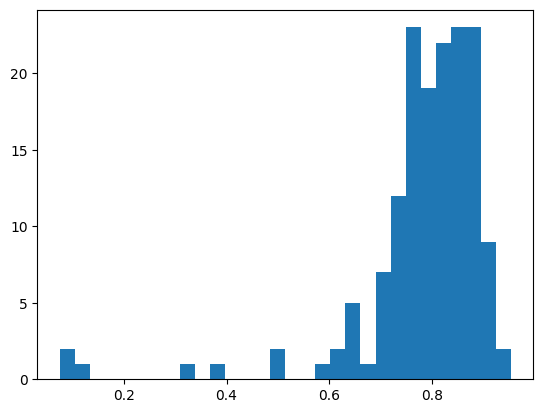

In [12]:
from matplotlib import pyplot as plt

plt.hist(calibrated_KGES[calibrated_KGES>0], bins = 30)
plt.show()

In [13]:
calibrated_KGES.mean()

0.7715099828991685

In [14]:
np.median(calibrated_KGES)

0.807751787084527

In [15]:
calibrated_KGES

array([ 0.88486105,  0.92163191,  0.87546981,  0.84001138,  0.86774617,
        0.80657348,  0.85995431,  0.76375372,  0.87440465,  0.87536767,
        0.79992148, -0.98911256,  0.78704862,  0.87482489,  0.71045009,
        0.83883911,  0.90895585,  0.76069099,  0.6169195 ,  0.84939578,
        0.75764799,  0.76283788,  0.83580685,  0.90435629,  0.88336106,
        0.837605  ,  0.31405577,  0.72885325,  0.8661782 ,  0.95370085,
        0.73580431,  0.87092044,  0.7167404 ,  0.78278838,  0.79134153,
        0.8421196 ,  0.84851972,  0.7492703 ,  0.86392071,  0.50289944,
        0.91330215,  0.65508797,  0.88559262,  0.83464509,  0.86782511,
        0.90623548,  0.82971698,  0.78753946,  0.90452606,  0.85518528,
        0.88972177,  0.76596194,  0.77750783,  0.71334511,  0.86479854,
        0.87407735,  0.79475722,  0.79257071,  0.88875779,  0.07548448,
        0.74548108,  0.75085878,  0.86053581,  0.78088558,  0.93608383,
        0.82481263,  0.70321427,  0.71443241,  0.77673949,  0.86